# Reverse Uncertainty Calculation

Consider measuring the of density of a cylinder by measuring it's height, diameter, and mass:

$\rho = \frac{m}{\pi (d/2)^2 h}$

The product specification for the cylinder lists a density requirement of $2.00 \pm 0.06 \, \mathrm{g/cm^3}$ (95% confidence). From the manufacturing process, the height and diameter are given as $h=1.5$ cm and $d=1.0$ cm with uncertainty of $0.01$ cm (95% confidence). What range of measured mass values result in an acceptable density?

In [1]:
import numpy as np
import suncal
from suncal import reverse

In [2]:
# Define the cylinder parameters
rho_req = 2
urho_req = .06     # 95%
d, h = 1.0, 1.5
ud, uh = .01, .01  # 95%

## The WRONG way

A naive solution would be to simply flip around the measurement function, solving for $m$, and run through the calculator:

In [3]:
u = suncal.UncertCalc('m = rho * pi/4 * d**2 * h')
u.set_input('rho', nom=rho_req, unc=urho_req, conf=.95)
u.set_input('h', nom=h, unc=uh, conf=.95)
u.set_input('d', nom=d, unc=ud, conf=.95)
u.calculate()
u.out.report_summary(n=4)

Function   | Method       | Nominal   | Std. Uncertainty   | 95% Coverage   | k         | Deg. Freedom  
----------|------------|---------|------------------|--------------|---------|--------------
$m$   | GUM          | 2.35619   | 0.04408            | ± 0.08639      | 1.960     | inf           
$m$   | Monte Carlo  | 2.35625   | 0.04410            | (2.27036 , 2.44327 ) | 1.961     | -             


![IMG0][]



[IMG0]: 

However, checking this computed mass, $2.36 \pm 0.044$ g, using a forward calculation for density produces an incorrect result! We get 95% coverage range of $\pm 0.085$ instead of $\pm 0.060$ as required. In other words, using this mass limit, there is a greater than the acceptable 5% chance of accepting an out-of-tolerance part.

The incorrect result stems from two factors: (1) the linearity of the Taylor expansion used by GUM method may not be reversible, (2) the calculation neglects the fact that $\rho$ is now correlated with the other input variables.

In [4]:
u2 = suncal.UncertCalc('rho = m / (pi/4 * d**2 * h)')
u2.set_input('m', nom=u.out.gum.nom('m'), std=u.out.gum.uncert('m'))
u2.set_input('h', nom=h, unc=uh, conf=.95)
u2.set_input('d', nom=d, unc=ud, conf=.95)
u2.calculate()
u2.out.report_summary(n=4)

Function   | Method       | Nominal   | Std. Uncertainty   | 95% Coverage   | k         | Deg. Freedom  
----------|------------|---------|------------------|--------------|---------|--------------
$\rho$   | GUM          | 2.00000   | 0.04316            | ± 0.08459      | 1.960     | inf           
$\rho$   | Monte Carlo  | 2.00012   | 0.04317            | (1.91609 , 2.08533 ) | 1.960     | -             


![IMG0][]



[IMG0]: 

## Correct way

A proper reverse uncertainty calculation can be performed by finding $u_{\rho}$ and solving for $u_m$. The Uncertainy Calculator can do this for you, along with a correct Monte-Carlo approach which includes correlation effects, using the reverse_calc() method of UncertaintyCalc objects.

In [5]:
u3 = reverse.UncertReverse('rho = m / (pi/4 * d**2 * h)', targetnom=rho_req, targetunc=urho_req/1.96, solvefor='m')
# Use urho_req/1.96 to get k=1
u3.set_input('h', nom=h, unc=uh, conf=.95)  # Add known inputs. Don't need to specify 'm'.
u3.set_input('d', nom=d, unc=ud, conf=.95)

# Reverse calc value of m to acheive rho +/- urho
u3out = u3.calculate()
u3out.report(n=4)

## GUM reverse uncertainty

$\rho = \frac{4 m}{\pi d^{2} h}$

 Combined uncertainty:

$u_{\rho} = \sqrt{\frac{4 \left(\frac{4 u_{m}^{2}}{\pi d^{2} h} - \frac{4 m \sigma_{hm} u_{h} u_{m}}{\pi d^{2} h^{2}} - \frac{8 m \sigma_{dm} u_{d} u_{m}}{\pi d^{3} h}\right)}{\pi d^{2} h} - \frac{4 m \left(\frac{4 \sigma_{hm} u_{h} u_{m}}{\pi d^{2} h} - \frac{4 m u_{h}^{2}}{\pi d^{2} h^{2}} - \frac{8 m \sigma_{dh} u_{d} u_{h}}{\pi d^{3} h}\right)}{\pi d^{2} h^{2}} - \frac{8 m \left(\frac{4 \sigma_{dm} u_{d} u_{m}}{\pi d^{2} h} - \frac{4 m \sigma_{dh} u_{d} u_{h}}{\pi d^{2} h^{2}} - \frac{8 m u_{d}^{2}}{\pi d^{3} h}\right)}{\pi d^{3} h}}$

solved for uncertainty of input:

$u_{m} = \frac{\frac{\pi d^{2} h \rho \left(d \sigma_{hm} u_{h} + 2 h \sigma_{dm} u_{d}\right)}{4} + \frac{\sqrt{\pi^{2} d^{6} h^{4} u_{\rho}^{2} + \pi^{2} d^{6} h^{2} \rho^{2} \sigma_{hm}^{2} u_{h}^{2} - \pi^{2} d^{6} h^{2} \rho^{2} u_{h}^{2} - 4 \pi^{2} d^{5} h^{3} \rho^{2} \sigma_{dh} u_{d} u_{h} + 4 \pi^{2} d^{5} h^{3} \rho^{2} \sigma_{dm} \sigma_{hm} u_{d} u_{h} + 4 \pi^{2} d^{4} h^{4} \rho^{2} \sigma_{dm}^{2} u_{d}^{2} - 4 \pi^{2} d^{4} h^{4} \rho^{2} u_{d}^{2}}}{4}}{d h}$

 For output value of 
2.00000 
 ± 
0.03061 
 (k=1),

required input value is 
2.35619 
 ± 
0.02566 
 (k=1).



---

## Monte Carlo reverse uncertainty

For output value of 
2.00000 
 ± 
0.03061 
 (k=1), required input value is: 
2.35598 
 ± 
0.02565 
 (k=1).

Now if we plug this result ($2.36 \pm 0.026$ g) back in, we should get the required 95% uncertainty of $2.0 \pm 0.060$ g exactly.

In [6]:
u4 = suncal.UncertCalc('rho = m / (pi/4 * d**2 * h)')   # Set up in forward direction
u4.set_input('m', nom=u3out.gumdata['i'], std=u3out.gumdata['u_i'])
u4.set_input('h', nom=h, unc=uh, conf=.95)
u4.set_input('d', nom=d, unc=ud, conf=.95)
u4.calculate()
u4.out.report_summary(n=4)

Function   | Method       | Nominal   | Std. Uncertainty   | 95% Coverage   | k         | Deg. Freedom  
----------|------------|---------|------------------|--------------|---------|--------------
$\rho$   | GUM          | 2.00000   | 0.03061            | ± 0.06000      | 1.960     | inf           
$\rho$   | Monte Carlo  | 2.00018   | 0.03063            | (1.94073 , 2.06075 ) | 1.959     | -             


![IMG0][]



[IMG0]: 

## Using worst-case mass

Sometimes, it is tempting to simply calculate the worst case value for mass using the highest and lowest values for each input variable. This method also results in a density uncertainty well above the $0.0600$ requirement.

In [7]:
# Calculate highest and lowest 95% range input values
rho_hi = rho_req + urho_req
rho_lo = rho_req - urho_req
d_hi = d + ud
d_lo = d - ud
h_hi = h + uh
h_lo = h - uh

# Highest and lowest mass
mhi = rho_hi * np.pi/4 * d_hi**2 * h_hi
mlo = rho_lo * np.pi/4 * d_lo**2 * h_lo
m = (mhi + mlo)/2
um = (mhi - m)
print('Worst Case m = {:.6f} +/- {:.6f} (95%)'.format(m, um))

# Plug in to forward calculation, see resulting rho range
u5 = suncal.UncertCalc('rho = m / (pi/4 * d**2 * h)')
u5.set_input('m', nom=m, unc=um, conf=.95)
u5.set_input('h', nom=h, unc=uh, conf=.95)
u5.set_input('d', nom=d, unc=ud, conf=.95)
u5.calculate()
u5.out.report_summary(n=4)

Worst Case m = 2.358629 +/- 0.133536 (95%)


Function   | Method       | Nominal   | Std. Uncertainty   | 95% Coverage   | k         | Deg. Freedom  
----------|------------|---------|------------------|--------------|---------|--------------
$\rho$   | GUM          | 2.00207   | 0.06171            | ± 0.1210      | 1.960     | inf           
$\rho$   | Monte Carlo  | 2.00223   | 0.06175            | (1.88169 , 2.12379 ) | 1.960     | -             


![IMG0][]



[IMG0]: 

In [8]:
# Generate some figures illustrating the distributions
import matplotlib.pyplot as plt
import scipy.stats as stats

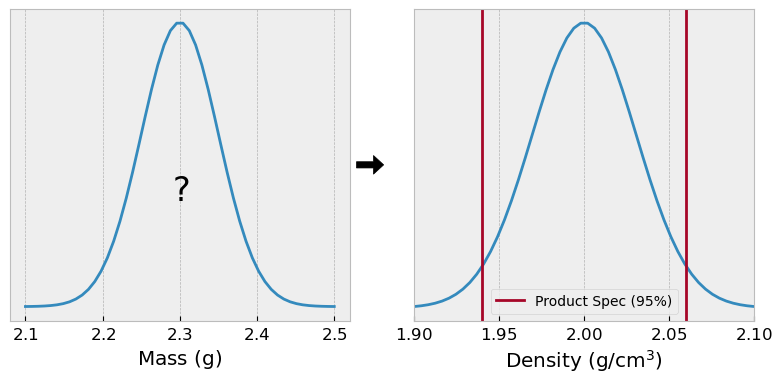

In [9]:
# Product spec limits. 95% of measured values should fall within this limit.
fig, ax = plt.subplots(ncols=2, figsize=(8,4))

xx = np.linspace(2.1, 2.5)
yy = stats.norm.pdf(xx, loc=2.3, scale=.05)
ax[0].plot(xx, yy)
ax[0].axes.get_yaxis().set_visible(False)
ax[0].text(2.29, 3, '?', fontsize=24)
ax[0].set_xlabel('Mass ($g$)')
ax[0].arrow(1.02, 0.5, .05, 0, clip_on=False, color='black', 
            width=.02, head_length=.03, transform=ax[0].transAxes)

xx = np.linspace(1.9, 2.1)
yy = stats.norm.pdf(xx, loc=2, scale=0.06/1.96)
ax[1].plot(xx, yy)
ax[1].axvline(rho_req+urho_req, color='C1', label='Product Spec (95%)')
ax[1].axvline(rho_req-urho_req, color='C1')
ax[1].set_xlim(1.9, 2.1)
ax[1].legend(loc='lower center', fontsize=10)
ax[1].set_xlabel('Density ($g/cm^3$)');
ax[1].axes.get_yaxis().set_visible(False)
fig.tight_layout();

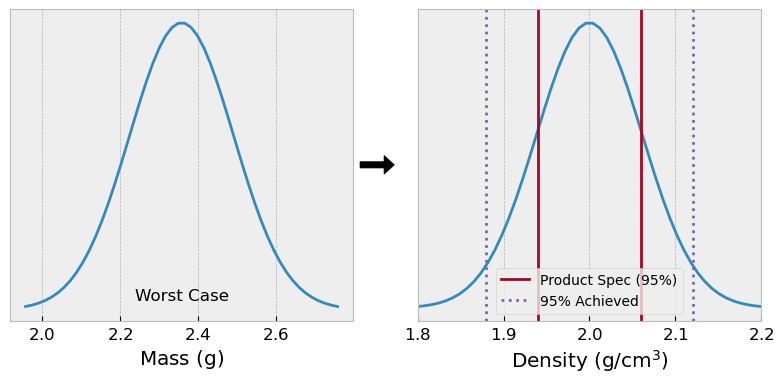

In [10]:
# Using worst-case. If you accept any product with
# Product spec limits. 95% of measured values should fall within this limit.
fig, ax = plt.subplots(ncols=2, figsize=(8,4))

mass = m
umass = um
urho = u5.out.gum.uncert().magnitude*1.96

xx = np.linspace(mass-3*umass, mass+3*umass)
yy = stats.norm.pdf(xx, loc=mass, scale=umass)
ax[0].plot(xx, yy)
ax[0].axes.get_yaxis().set_visible(False)
ax[0].text(mass, .1, 'Worst Case', fontsize=12, horizontalalignment='center')
ax[0].set_xlabel('Mass ($g$)')
ax[0].arrow(1.02, 0.5, .07, 0, clip_on=False, color='black', 
            width=.02, head_length=.03, transform=ax[0].transAxes)

xx = np.linspace(1.8, 2.2)
yy = stats.norm.pdf(xx, loc=rho_req, scale=urho/1.96)
ax[1].plot(xx, yy)
ax[1].axvline(rho_req+urho_req, color='C1', label='Product Spec (95%)')
ax[1].axvline(rho_req-urho_req, color='C1')
plt.axvline(rho_req-urho, color='C2', ls=':', label='95% Achieved')
plt.axvline(rho_req+urho, color='C2', ls=':')
ax[1].legend(loc='lower center', fontsize=10)
ax[1].set_xlabel('Density ($g/cm^3$)');
ax[1].axes.get_yaxis().set_visible(False)
ax[1].set_xlim(xx.min(), xx.max())
fig.tight_layout()

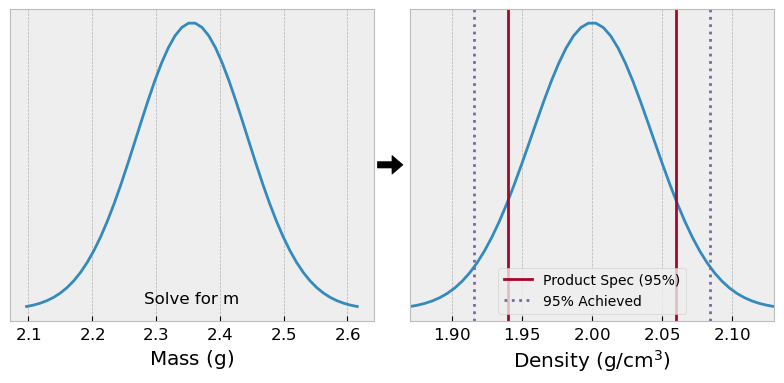

In [11]:
# Using algebraically reversed calculation for m. If you accept any product with
# m = 2.35619 +/- 0.04408, more than 5% will be outside spec!
fig, ax = plt.subplots(ncols=2, figsize=(8,4))

mass = u.out.gum.nom().magnitude
umass = u.out.gum.uncert().magnitude*1.96
urho = u2.out.gum.uncert().magnitude*1.96

xx = np.linspace(mass-3*umass, mass+3*umass)
yy = stats.norm.pdf(xx, loc=mass, scale=umass)
ax[0].plot(xx, yy)
ax[0].axes.get_yaxis().set_visible(False)
ax[0].text(mass, .1, 'Solve for m', fontsize=12, horizontalalignment='center')
ax[0].set_xlabel('Mass ($g$)')
ax[0].arrow(1.01, 0.5, .04, 0, clip_on=False, color='black', 
            width=.02, head_length=.03, transform=ax[0].transAxes)

xx = np.linspace(1.87, 2.13)
yy = stats.norm.pdf(xx, loc=rho_req, scale=urho/1.96)
ax[1].plot(xx, yy)
ax[1].axvline(rho_req+urho_req, color='C1', label='Product Spec (95%)')
ax[1].axvline(rho_req-urho_req, color='C1')#, ls=':')
plt.axvline(rho_req-urho, color='C2', ls=':', label='95% Achieved')
plt.axvline(rho_req+urho, color='C2', ls=':')
ax[1].legend(loc='lower center', fontsize=10)
ax[1].set_xlabel('Density ($g/cm^3$)');
ax[1].axes.get_yaxis().set_visible(False)
ax[1].set_xlim(xx.min(), xx.max())
fig.tight_layout()
fig.subplots_adjust(wspace=.1)

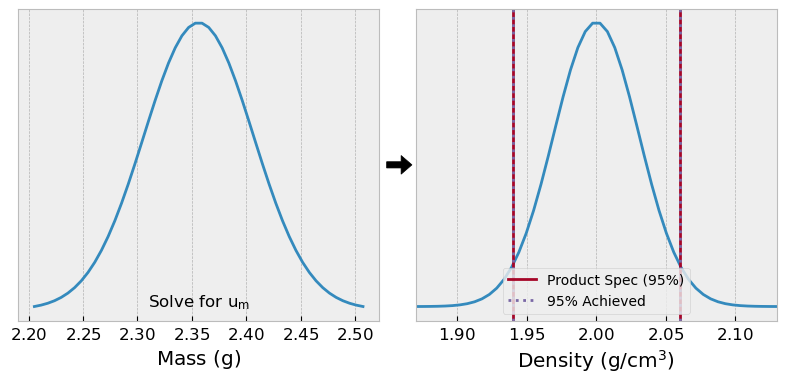

In [12]:
# Using proper reverse calculation to find u_m. If you accept any product with
# m = 2.35619 +/- 0.02566, exactly than 5% will be outside spec, as required.
fig, ax = plt.subplots(ncols=2, figsize=(8,4))

mass = u3out.gumdata['i'].magnitude
umass = u3out.gumdata['u_i'].magnitude*1.96
urho = u4.out.gum.uncert().magnitude*1.96

xx = np.linspace(mass-3*umass, mass+3*umass)
yy = stats.norm.pdf(xx, loc=mass, scale=umass)
ax[0].plot(xx, yy)
ax[0].axes.get_yaxis().set_visible(False)
ax[0].text(mass, .1, 'Solve for $u_m$', fontsize=12, horizontalalignment='center')
ax[0].set_xlabel('Mass ($g$)')
ax[0].arrow(1.02, 0.5, .04, 0, clip_on=False, color='black', 
            width=.02, head_length=.03, transform=ax[0].transAxes)

xx = np.linspace(1.87, 2.13)
yy = stats.norm.pdf(xx, loc=rho_req, scale=urho/1.96)
ax[1].plot(xx, yy)
ax[1].axvline(rho_req+urho_req, color='C1', label='Product Spec (95%)')
ax[1].axvline(rho_req-urho_req, color='C1')#, ls=':')
plt.axvline(rho_req-urho, color='C2', ls=':', label='95% Achieved')
plt.axvline(rho_req+urho, color='C2', ls=':')
ax[1].legend(loc='lower center', fontsize=10)
ax[1].set_xlabel('Density ($g/cm^3$)');
ax[1].axes.get_yaxis().set_visible(False)
ax[1].set_xlim(xx.min(), xx.max())
fig.tight_layout()
fig.subplots_adjust(wspace=.1)

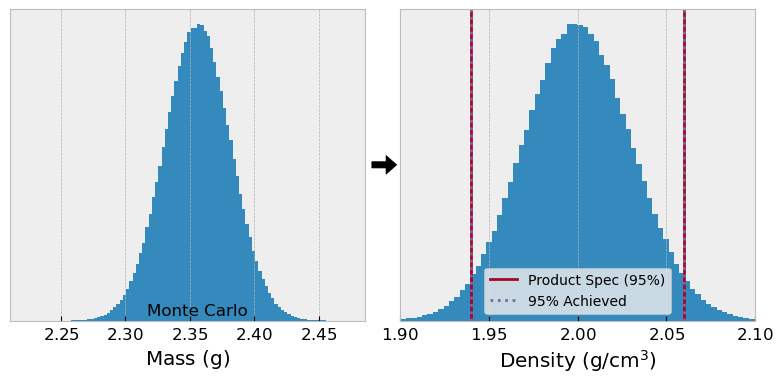

In [13]:
# Using Monte Carlo (histograms this time)
# m = 2.35619 +/- 0.02566, exactly than 5% will be outside spec, as required.
fig, ax = plt.subplots(ncols=2, figsize=(8,4))

c = u3out.mcdata['rev_ucalc']
mcout = c.out.mc

mass = mcout.nom().magnitude
umass = mcout.uncert().magnitude*1.96
urho = u4.out.gum.uncert().magnitude*1.96

ax[0].hist(mcout.samples().magnitude, bins=100, density=True)
ax[0].axes.get_yaxis().set_visible(False)
ax[0].text(mass, .3, 'Monte Carlo', fontsize=12, horizontalalignment='center')
ax[0].set_xlabel('Mass ($g$)')
ax[0].arrow(1.02, 0.5, .04, 0, clip_on=False, color='black', 
            width=.02, head_length=.03, transform=ax[0].transAxes)

ax[1].hist(u4.out.mc.samples().magnitude, bins=100)
ax[1].axvline(rho_req+urho_req, color='C1', label='Product Spec (95%)')
ax[1].axvline(rho_req-urho_req, color='C1')#, ls=':')
plt.axvline(rho_req-urho, color='C2', ls=':', label='95% Achieved')
plt.axvline(rho_req+urho, color='C2', ls=':')
ax[1].legend(loc='lower center', fontsize=10)
ax[1].set_xlabel('Density ($g/cm^3$)');
ax[1].axes.get_yaxis().set_visible(False)
ax[1].set_xlim(1.9, 2.1)
fig.tight_layout()
fig.subplots_adjust(wspace=.1)